## An Exploratory Data Analysis and Visualization for Text Data

<font size="4" color=#585858> How to apply visualization techique in NLP to generate insights in an intuitive way </font>

<figure>
    <figcaption>A maze of possible paths that could be taken in visual data exploration</figcaption>
    <img src="./images/maze.png" alt="maze" style="float:left; width: 400px;"/>     
</figure>

> Should the visualization be a bar or a line chart?<br>
> Should this attribute be plotted on the x-axis or encoded as a color?<br>
> How should the charts be laid out to facilitate comparisons between different values?

1. Basic visualization
2. Word Distribution
3. Similarity Analysis
4. Sentiment Analysis
5. Topic Modeling


In [0]:
#import packages

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import re

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator
import PIL

import gensim
from gensim.models import word2vec
from gensim.utils import lemmatize, simple_preprocess
import gensim.corpora as corpora

from sklearn.manifold import TSNE

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import os
import sys

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# The below two lines load the Drive helper and mount.
# You will see a link, click the link and paste the code to textbox on this page.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
IN_COLAB = 'google.colab' in sys.modules

In [0]:
sns.set(color_codes=True)

In [0]:
if IN_COLAB:
  dataset_name = 'Womens Clothing E-Commerce Reviews.csv'
  data = os.path.join("/content/drive/My Drive/NLP_LAB/dataset", dataset_name)
  df = pd.read_csv(data)
else:
  df = pd.read_csv('./dataset/Womens Clothing E-Commerce Reviews.csv')

In [0]:
# After executing this line, you need to restart runtime. Please go to the menu bar, click Runtime -> Restart Runtime 
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 72.8MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=0e478b8165c2c8486bc93e608fe23f6bcccf0f7d8fd62c69285a4bb74857be40
  Stored in directory: /tmp/pip-ephem-wheel-cache-qfgpu55p/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


#### Explore Dataset

In [0]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i n...",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and really wanted it to work for me. i initially ordered th...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get no...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length t...,5,1,6,General,Tops,Blouses


In [0]:
# Clean data
df.drop('Unnamed: 0', axis=1, inplace=True) # drop Unnamed column
df.drop('Title', axis=1, inplace=True) # Remove the “Title” feature
df = df[~df['Review Text'].isnull()]   # Remove the rows where “Review Text” were missing.

In [0]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

df['Review Text'] = preprocess(df['Review Text'])

### Basic Visualization

#### Plotting univariate distributions 

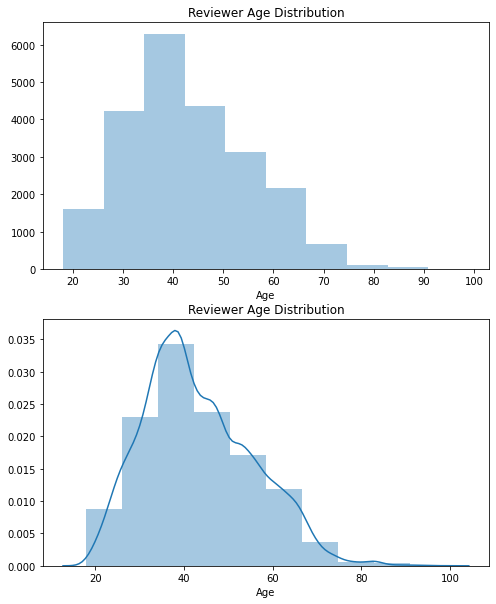

In [0]:
fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

sns.distplot(df['Age'], bins=10, kde=False, ax=ax1).set(title="Reviewer Age Distribution")
sns.distplot(df['Age'], bins=10, ax=ax2).set(title="Reviewer Age Distribution")
plt.show()

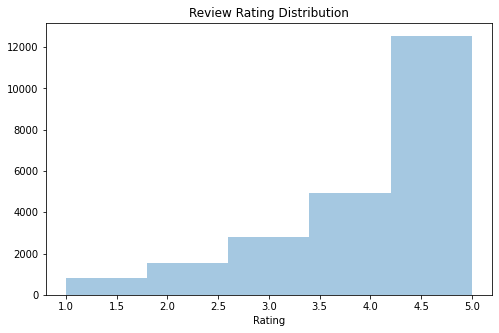

In [0]:
fig = plt.figure(figsize=(8,5))
sns.distplot(df['Rating'], bins=5, kde=False).set(title="Review Rating Distribution")
plt.show()

#### The distribution of department

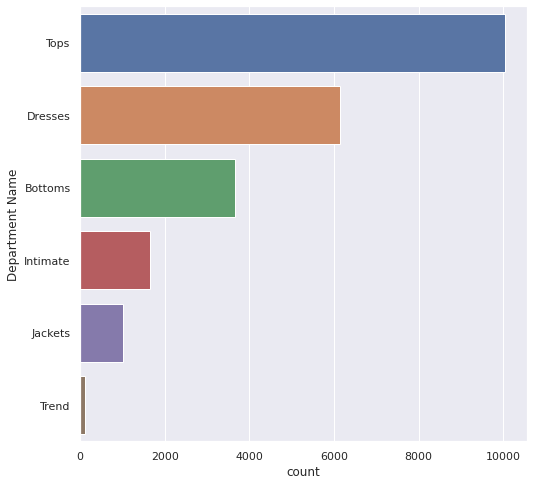

In [0]:
sns.set(color_codes=False)
fig = plt.figure(figsize=(8,8))
sns.countplot(y="Department Name", data=df, order=df['Department Name'].value_counts().index)
plt.show()

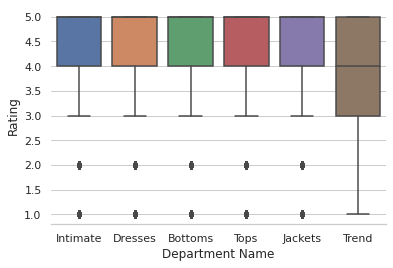

In [0]:
sns.set_style("whitegrid")
sns.boxplot(x='Department Name', y='Rating', data=df)
sns.despine(left=True)

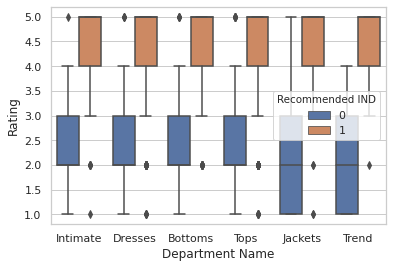

In [0]:
g = sns.boxplot(x="Department Name", y="Rating", hue="Recommended IND", data=df)

##### The distribution of Class

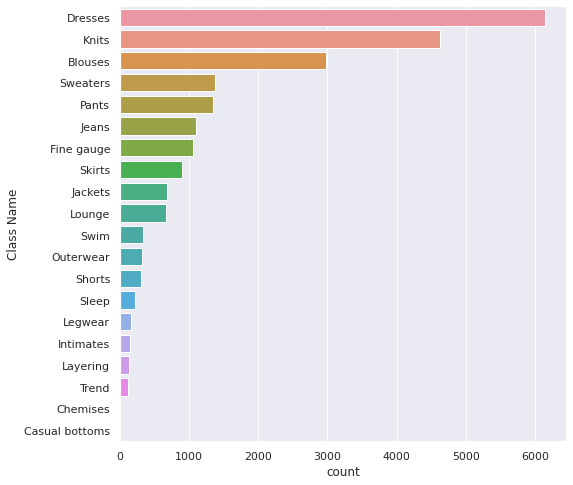

In [0]:
sns.set(color_codes=False)
fig = plt.figure(figsize=(8,8))
sns.countplot(y="Class Name", data=df, order=df['Class Name'].value_counts().index)
plt.show()

#### Plotting bivariate distributions

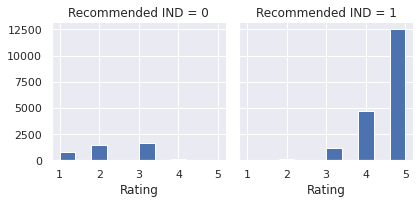

In [0]:
# multi-plot grids
g = sns.FacetGrid(df, col="Recommended IND")
g.map(plt.hist, "Rating")

### Word Distribution

##### The distribution of top unigrams before removing stop words

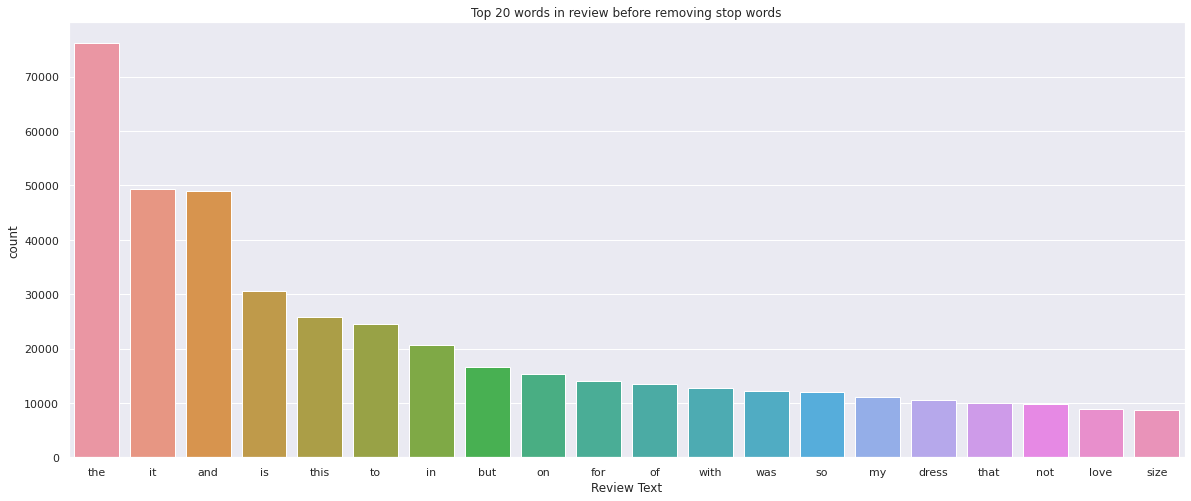

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['Review Text'], 20)
    
df_top20 = pd.DataFrame(common_words, columns = ['Review Text' , 'count'])

sns.set(color_codes=False)
fig = plt.figure(figsize=(20,8))
sns.barplot(x="Review Text", y="count", data=df_top20).set(title="Top 20 words in review before removing stop words")
plt.show()

#### The distribution of top unigrams after removing stop words

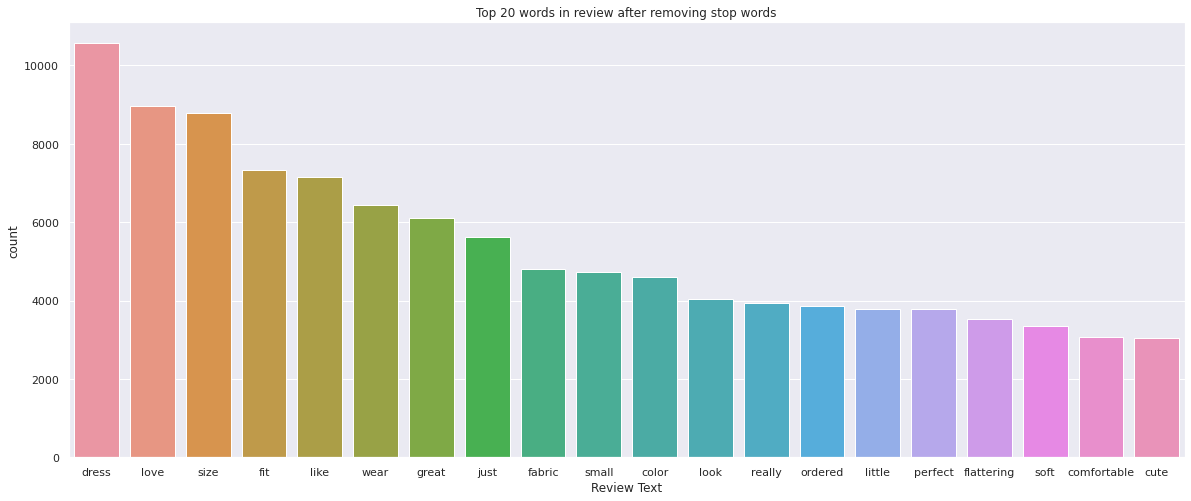

In [0]:

def get_top_n_words_no_stopwords(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words_no_stopwords = get_top_n_words_no_stopwords(df['Review Text'], 20)

df_top20_no_stopwords = pd.DataFrame(common_words_no_stopwords, columns = ['Review Text' , 'count'])

sns.set(color_codes=False)
fig = plt.figure(figsize=(20,8))
sns.barplot(x="Review Text", y="count", data=df_top20_no_stopwords).set(title="Top 20 words in review after removing stop words")
plt.show()

#### Word Cloud

In [0]:
corpus = ' '.join(df['Review Text'].tolist())

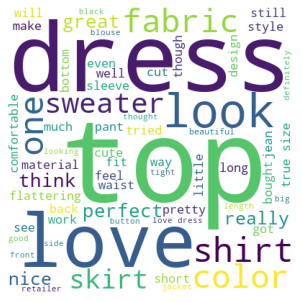

In [0]:
stopwords = set(STOPWORDS) 
wc = WordCloud(width = 400, height = 400,
                #mask=char_mask,
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus) 
  
# plot the WordCloud image                        
fig = plt.figure(1, facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

##### Creating wordcloud following a color pattern

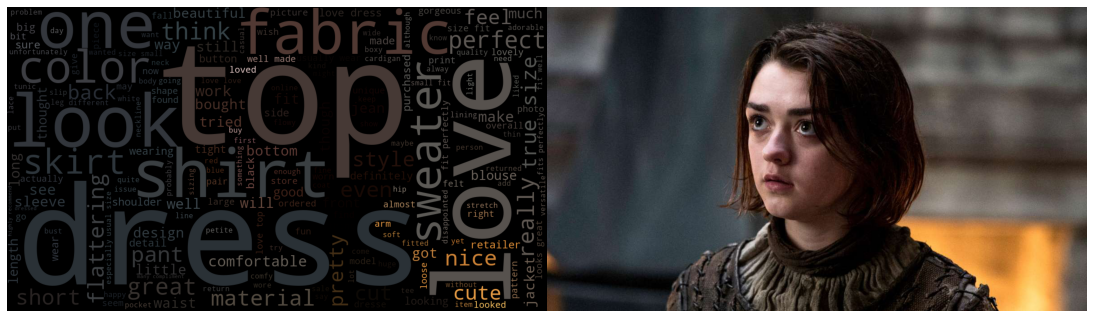

In [0]:
if IN_COLAB:
  img_src = os.path.join("/content/drive/My Drive/NLP_LAB/dataset", "arya.jpeg")
else:
  img_src = os.path.join("./dataset", "arya.jpeg")

char_mask = np.array(PIL.Image.open(img_src))
image_colors = ImageColorGenerator(char_mask)

# Generate a word cloud image
stopwords = set(STOPWORDS) 
wc = WordCloud(width = 400, height = 400,
                mask=char_mask,
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus) 
  
# plot the WordCloud image                        
fig = plt.figure(1, figsize=(15,15), facecolor = None) 
fig.add_subplot(1,2,1)
plt.imshow(wc.recolor(color_func=image_colors)) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
#plt.show() 

fig.add_subplot(1,2,2)
plt.axis("off") 
plt.imshow(char_mask) 

### Similarity Analysis

In [0]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [0]:
# Run Cell to Load Word Vectors
wv_from_bin = load_embedding_model()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



Loaded vocab size 400000


In [0]:
wv_from_bin.similar_by_word('dress')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('dresses', 0.8123365044593811),
 ('wear', 0.7470204830169678),
 ('attire', 0.7449464797973633),
 ('wearing', 0.7348757982254028),
 ('gown', 0.7288382649421692),
 ('wore', 0.7105982899665833),
 ('dressed', 0.7050216197967529),
 ('worn', 0.6984490752220154),
 ('skirt', 0.6849492788314819),
 ('clothes', 0.6733168959617615)]

In [0]:
words=word_tokenize(corpus)
unique_words = set(words)

In [0]:
def display_closestwords_tsnescatterplot(model, words, corpus):
    arr = np.empty((0,200), dtype='f')
    word_labels = []
    print(words)
    for word in words:      
        word_labels.append(word)

        # get close words
        close_words = model.similar_by_word(word, topn=5)
        close_words_in_corpus = [x for x in close_words if x[0] in corpus]

        # add the vector for each of the closest words to the array
        arr = np.append(arr, np.array([model[word]]), axis=0)
        
        for wrd_score in close_words_in_corpus:
            wrd_vector = model[wrd_score[0]]
            word_labels.append(wrd_score[0])
            arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(20, 15), dpi=200)
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        
    plt.show()

['dress', 'love', 'size', 'fit', 'like', 'wear', 'great', 'just', 'fabric', 'small', 'color', 'look', 'really', 'ordered', 'little', 'perfect', 'flattering', 'soft', 'comfortable', 'cute']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



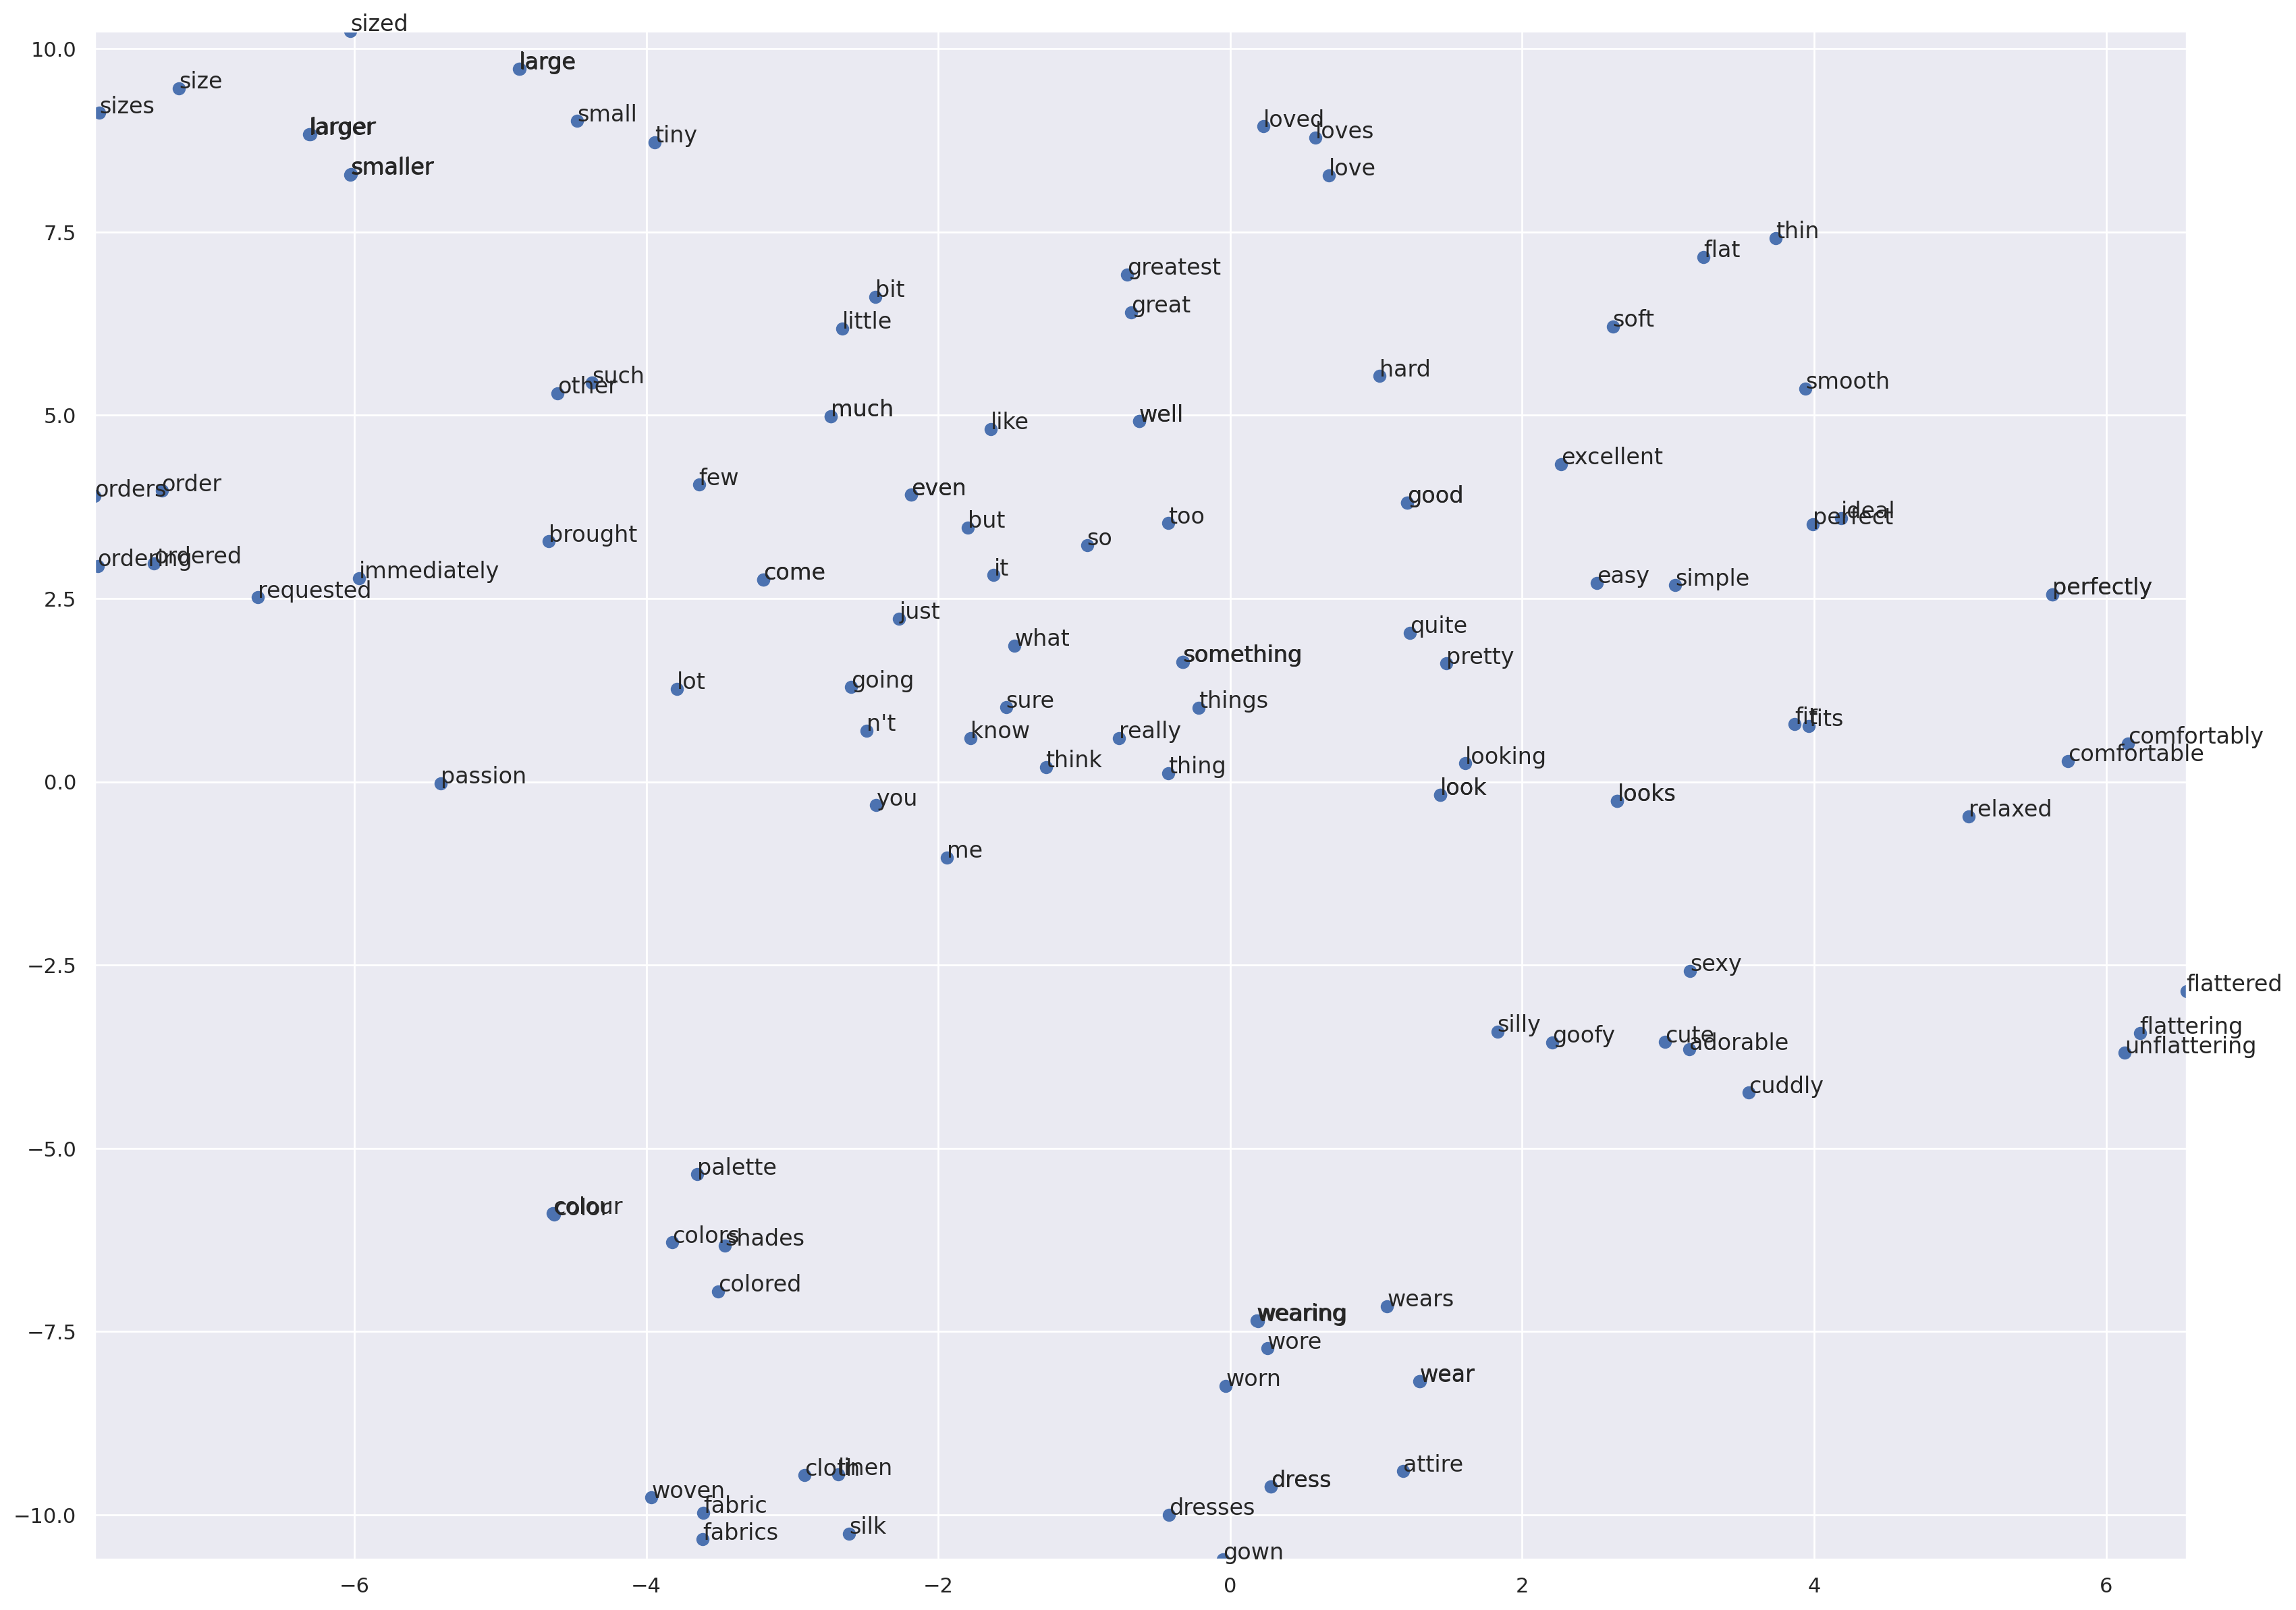

In [0]:
first_tuple_elements = [a_tuple[0] for a_tuple in common_words_no_stopwords]
display_closestwords_tsnescatterplot(wv_from_bin, first_tuple_elements, unique_words)

#### Compare ratings and sentiment

In [0]:
sid = SentimentIntensityAnalyzer()
sentiment = df['Review Text'].map(lambda text: sid.polarity_scores(text))
df = pd.concat([df,sentiment.apply(pd.Series)],1)

In [0]:
print('5 random reviews with the highest positive sentiment polarity: \n')

cl = df.loc[df['compound'] > 0.95, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest positive sentiment polarity: 

Loved this sweater coat the first time i saw it online......then the price....yikes! the style, color and fabric design is beautiful. waited for it to sale and then hurray an extra 30%. off to my local store for a try on as i would not have wanted to even try it at the regular price. it is wonderful! it runs very large. i went down two sizes to achieve the fit i was looking for from a large to a small. in my opinion the product shot model is wearing a size too large. even sizing down it is not t

These joggers are gorgeous--you can even dress them up! the quality and softness is amazing and very expensive looking. the fit is perfect not to mention the fact that they are very flattering.
really, i knew the minute i saw them, i would love them. but, i do have to say that the lovely model
wearing them ---the model with the wine colored shirt and the awesome red bag (i bought that too!!!)and that big smile sold me!. many than

In [0]:
print("Polarity is in [%2f, %2f]" % (df['compound'].min(), df['compound'].max()))
print("The number of records %d " % (df.shape[0]))

# row in which value of 'compound' column is in [0,1]

s1 = df.apply(lambda x: True if x['compound'] >= 0 and x['compound'] <= 1 else False , axis=1)
numOfRows = len(s1[s1 == True].index)
print("The number of records in [0,1] is %d " % (numOfRows))

Polarity is in [-0.956200, 0.995900]
The number of records 22641 
The number of records in [0,1] is 21206 


In [0]:
c1 = df.loc[df['compound'] >= 0.0]
c1.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,neg,neu,pos,compound
count,21206.000000,21206.000000,21206.000000,21206.000000,21206.000000,21206.000000,21206.000000,21206.000000,21206.000000
mean,919.118363,43.278412,4.280015,0.850420,2.590493,0.027918,0.727218,0.244860,0.814947
std,202.458965,12.346304,1.034999,0.356668,5.739334,0.036387,0.116628,0.119709,0.209370
min,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000,0.000000,0.666000,0.161000,0.767800
50%,936.000000,41.000000,5.000000,1.000000,1.000000,0.014000,0.742000,0.225000,0.899600
75%,1078.000000,52.000000,5.000000,1.000000,3.000000,0.047000,0.806000,0.307000,0.952000
max,1205.000000,99.000000,5.000000,1.000000,122.000000,0.296000,1.000000,1.000000,0.995900


Dist plot of review polarity score

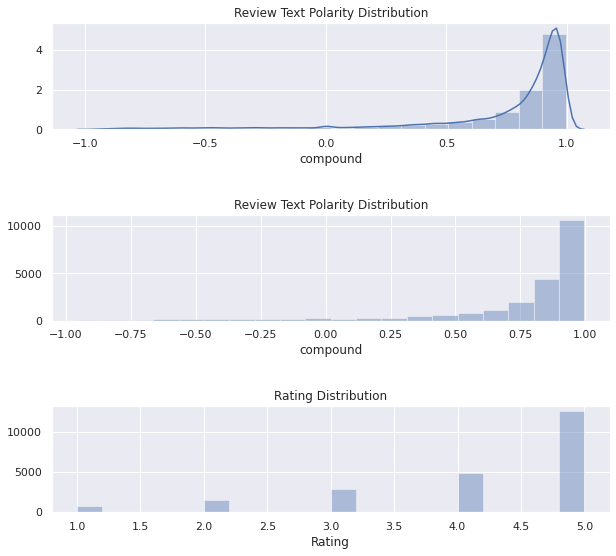

In [0]:
fig = plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace = 0.8)
gs = fig.add_gridspec(3,1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

sns.distplot(df['compound'], bins=20, kde=True, ax=ax1).set(title="Review Text Polarity Distribution")
sns.distplot(df['compound'], bins=20, kde=False, ax=ax2).set(title="Review Text Polarity Distribution")
sns.distplot(df['Rating'], bins=20,  kde=False, ax=ax3).set(title="Rating Distribution")
plt.show()

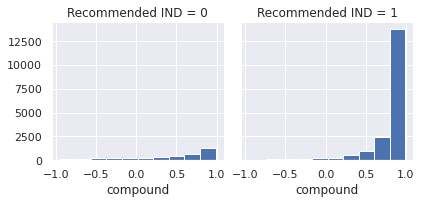

In [0]:
# multi-plot grids
g = sns.FacetGrid(df, col="Recommended IND")
g.map(plt.hist, "compound")

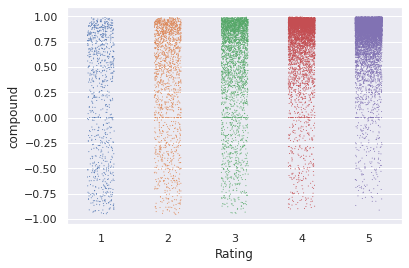

In [0]:
sns.stripplot(df['Rating'], df['compound'], jitter=0.2, size=1)

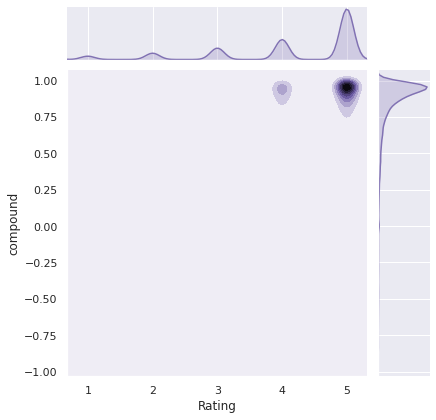

In [0]:
sns.jointplot(x="Rating", y="compound",  data=df, kind="kde", color="m").plot_joint(sns.kdeplot, zorder=0, n_levels=10)

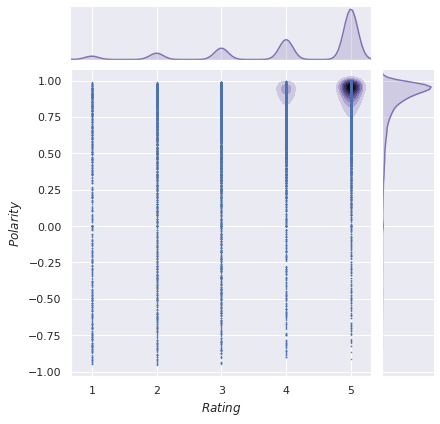

In [0]:
g = sns.jointplot(y="compound", x="Rating", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker='.')
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Rating$", "$Polarity$");

### Topic Modeling Visualization

#### Tokenize Sentences and Clean

In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['Review Text'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']]


In [0]:
stop_words = stopwords.words('english')

In [0]:
import spacy
spacy.prefer_gpu()
nlp=spacy.load('en_core_web_md')

#### Build the Bigram, Trigram Models and Lemmatize

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp=spacy.load('en_core_web_md')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.062*"size" + 0.042*"fit" + 0.034*"small" + 0.026*"order" + 0.021*"dress" + 0.020*"love" + 0.020*"try" + 0.020*"top" + 0.020*"would" + 0.019*"large"'), (1, '0.037*"color" + 0.035*"top" + 0.025*"look" + 0.024*"sleeve" + 0.024*"nice" + 0.023*"see" + 0.022*"short" + 0.015*"picture" + 0.014*"back" + 0.013*"pretty"'), (2, '0.043*"dress" + 0.038*"look" + 0.029*"fabric" + 0.021*"make" + 0.018*"think" + 0.018*"material" + 0.017*"fit" + 0.016*"waist" + 0.015*"feel" + 0.014*"good"'), (3, '0.061*"wear" + 0.051*"love" + 0.034*"great" + 0.027*"dress" + 0.027*"sweater" + 0.023*"perfect" + 0.021*"comfortable" + 0.019*"buy" + 0.018*"color" + 0.017*"soft"')]


In [0]:
print(lda_model.print_topics())

[(0, '0.062*"size" + 0.042*"fit" + 0.034*"small" + 0.026*"order" + 0.021*"dress" + 0.020*"love" + 0.020*"try" + 0.020*"top" + 0.020*"would" + 0.019*"large"'), (1, '0.037*"color" + 0.035*"top" + 0.025*"look" + 0.024*"sleeve" + 0.024*"nice" + 0.023*"see" + 0.022*"short" + 0.015*"picture" + 0.014*"back" + 0.013*"pretty"'), (2, '0.043*"dress" + 0.038*"look" + 0.029*"fabric" + 0.021*"make" + 0.018*"think" + 0.018*"material" + 0.017*"fit" + 0.016*"waist" + 0.015*"feel" + 0.014*"good"'), (3, '0.061*"wear" + 0.051*"love" + 0.034*"great" + 0.027*"dress" + 0.027*"sweater" + 0.023*"perfect" + 0.021*"comfortable" + 0.019*"buy" + 0.018*"color" + 0.017*"soft"')]


#### What is the Dominant topic and its percentage contribution in each document

In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Review_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7084,"wear, love, great, dress, sweater, perfect, co...","[absolutely, wonderful, silky, sexy, comfortable]"
1,1,0.0,0.8730,"size, fit, small, order, dress, love, try, top...","[love, dress, sooo, pretty, happen, find, stor..."
2,2,0.0,0.6953,"size, fit, small, order, dress, love, try, top...","[dress, really, want, work, initially, order, ..."
3,3,3.0,0.8508,"wear, love, great, dress, sweater, perfect, co...","[love, love, jumpsuit, fun, flirty, fabulous, ..."
4,4,3.0,0.7284,"wear, love, great, dress, sweater, perfect, co...","[shirt, flattering, due, adjustable, front, ti..."
5,5,0.0,0.6706,"size, fit, small, order, dress, love, try, top...","[love, dress, petite, usually, wear, brand, dr..."
6,6,1.0,0.7123,"color, top, look, sleeve, nice, see, short, pi...","[ade, basket, hte, last, mintue, see, would, l..."
7,7,0.0,0.3988,"size, fit, small, order, dress, love, try, top...","[order, carbon, store, pick, ton, stuff, alway..."
8,8,0.0,0.6603,"size, fit, small, order, dress, love, try, top...","[love, dress, usually, get, run, little, snug,..."
9,9,0.0,0.7947,"size, fit, small, order, dress, love, try, top...","[order, make, sure, length, long, typically, w..."


#### The most representative sentence for each topic

In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9578,"size, fit, small, order, dress, love, try, top, would, large","[cute, usually, wear, retailer, small, fit, perfectly, fit, snug, zip, usual, would, definitely,..."
1,1.0,0.9166,"color, top, look, sleeve, nice, see, short, picture, back, pretty","[really, pretty, top, different, color, style, deliver, timely, manner]"
2,2.0,0.9452,"dress, look, fabric, make, think, material, fit, waist, feel, good","[fabric, feel, look, cheap, hem, completely, fray, way, around, perhaps, purposely, ratty, look]"
3,3.0,0.9463,"wear, love, great, dress, sweater, perfect, comfortable, buy, color, soft","[love, shirt, casual, yet, fun, first, time, wear, receive, several, compliment, fun, tassel]"


####  Sentence Chart Colored by Topic

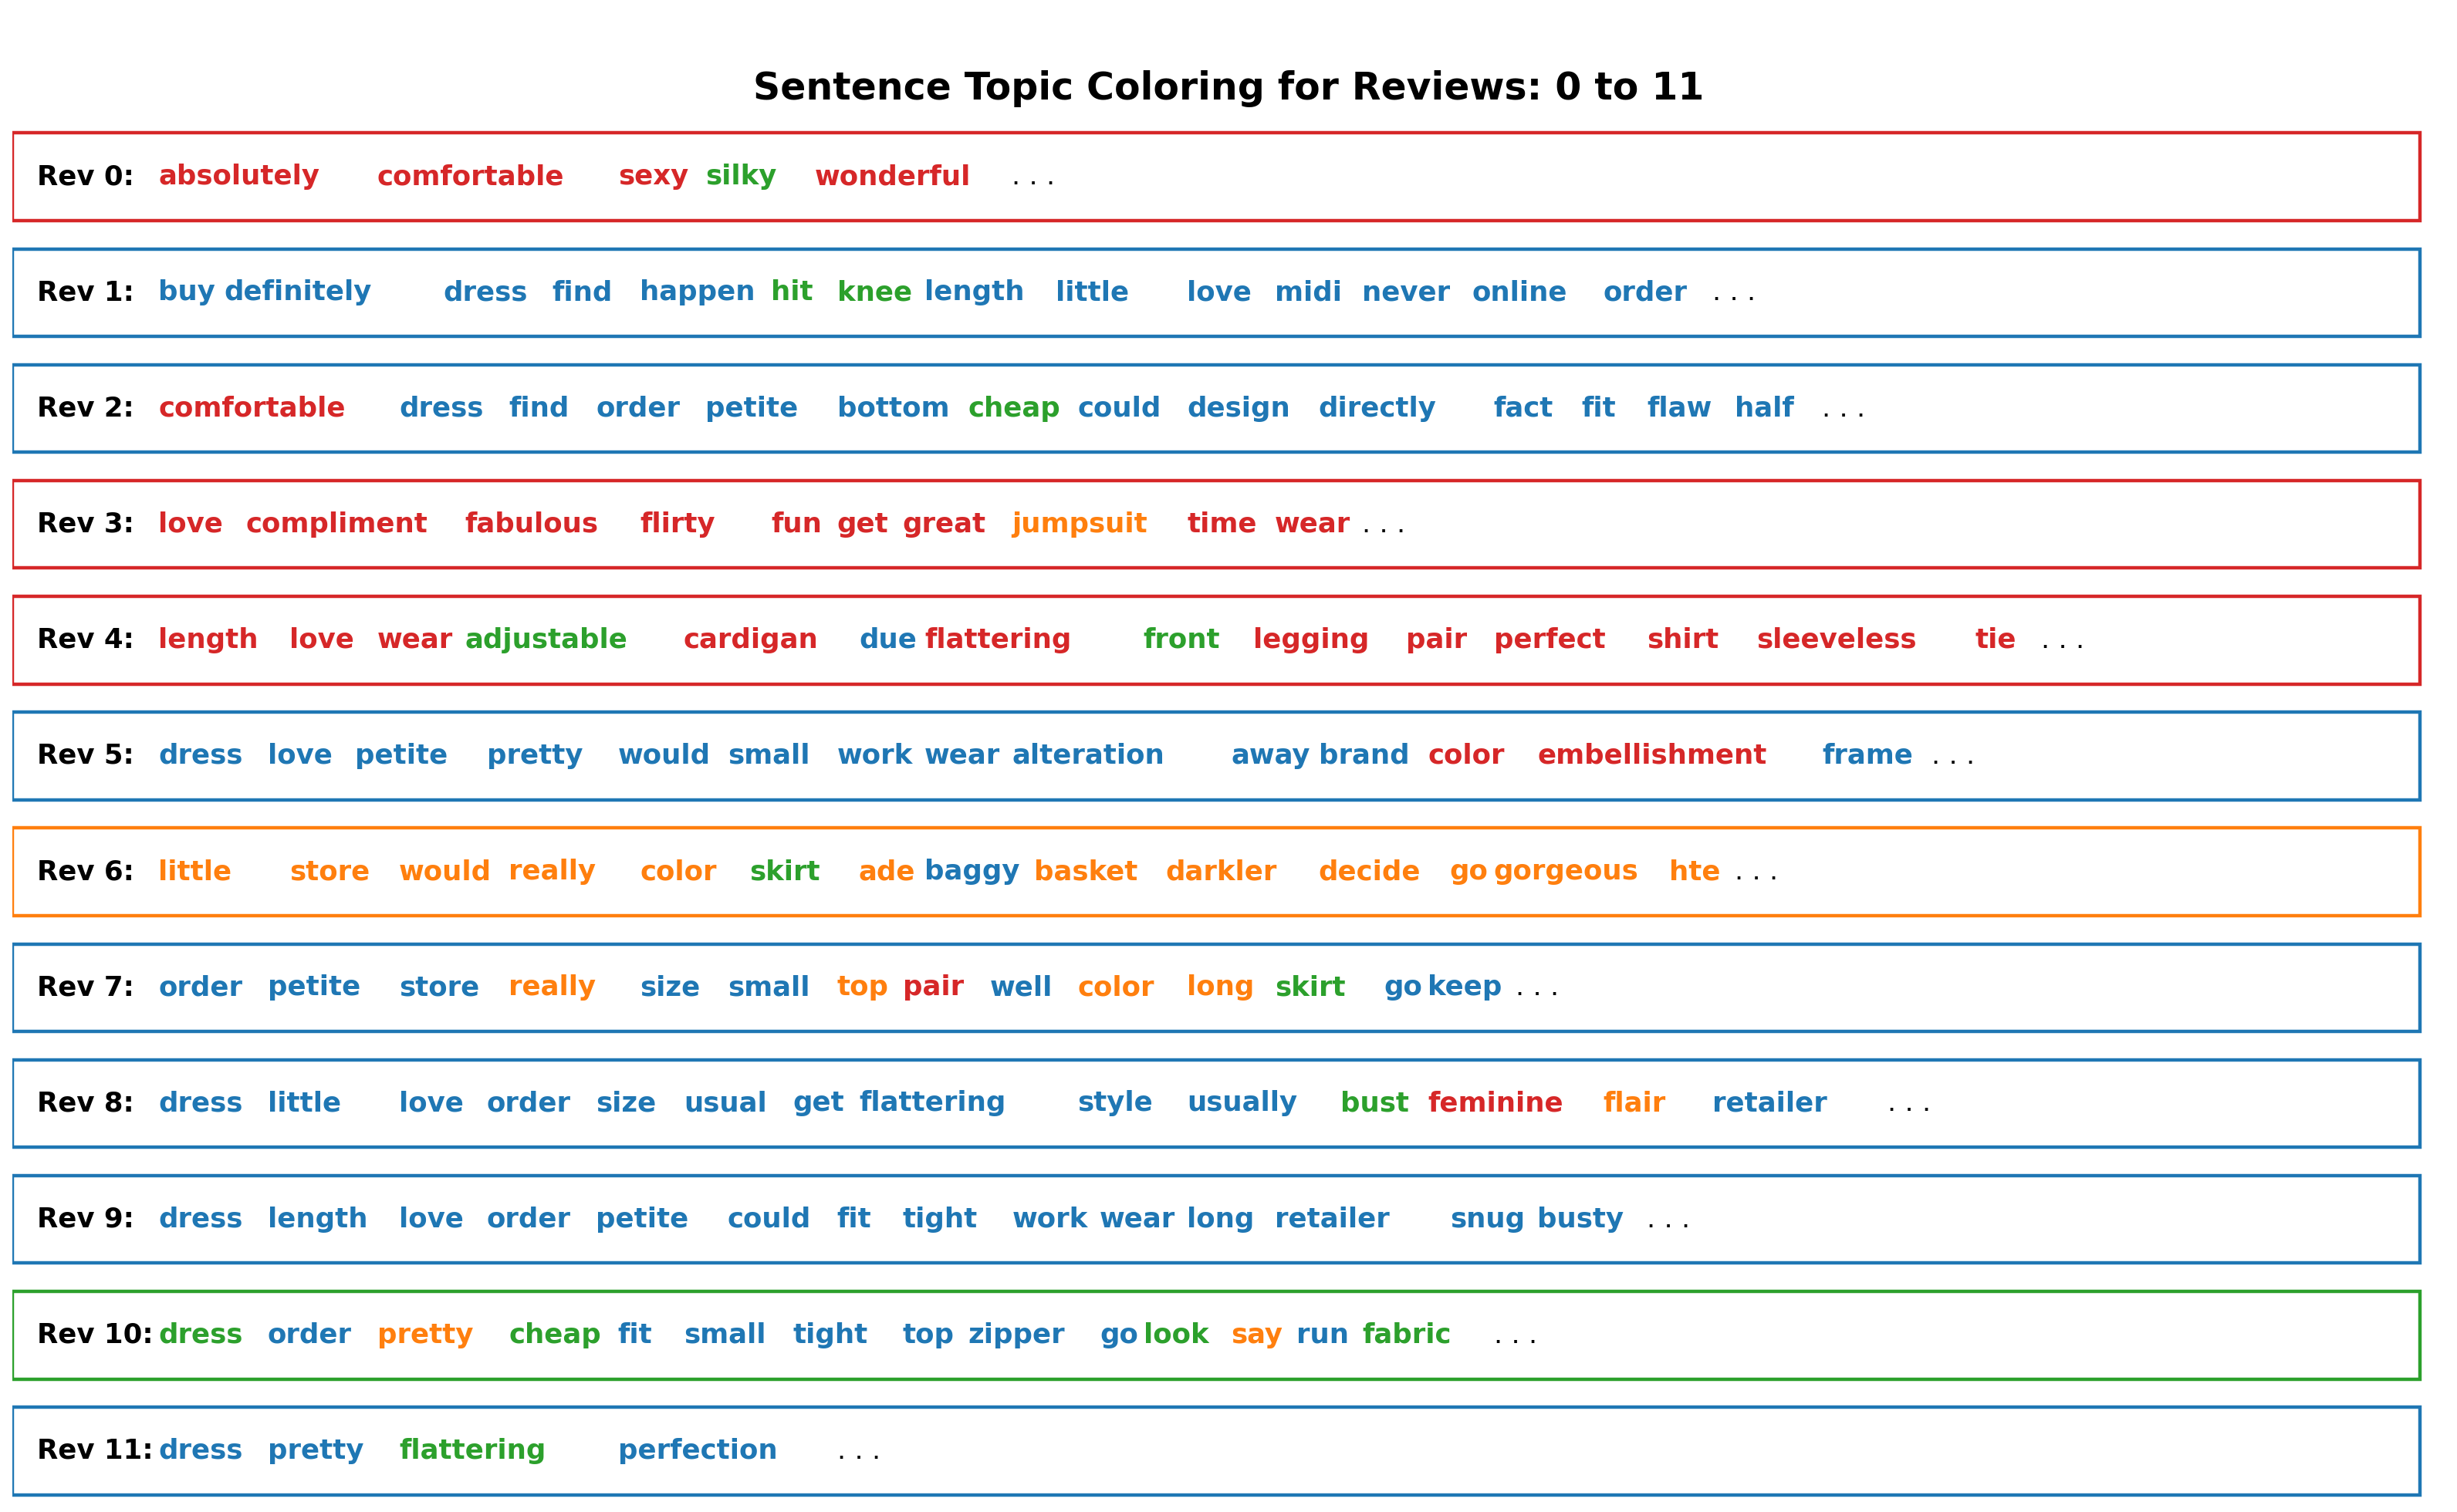

In [0]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Rev " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Reviews: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

#### What are the most discussed topics in the documents?

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

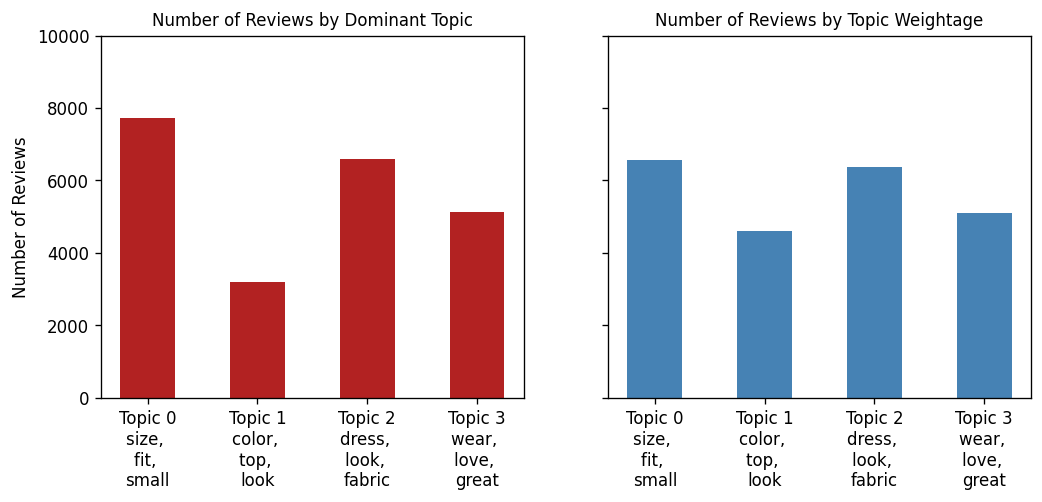

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Reviews by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Reviews')
ax1.set_ylim(0, 10000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Reviews by Topic Weightage', fontdict=dict(size=10))

plt.show()

####  t-SNE Clustering Chart

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19498 samples in 0.021s...
[t-SNE] Computed neighbors for 19498 samples in 0.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19498
[t-SNE] Computed conditional probabilities for sample 2000 / 19498
[t-SNE] Computed conditional probabilities for sample 3000 / 19498
[t-SNE] Computed conditional probabilities for sample 4000 / 19498
[t-SNE] Computed conditional probabilities for sample 5000 / 19498
[t-SNE] Computed conditional probabilities for sample 6000 / 19498
[t-SNE] Computed conditional probabilities for sample 7000 / 19498
[t-SNE] Computed conditional probabilities for sample 8000 / 19498
[t-SNE] Computed conditional probabilities for sample 9000 / 19498
[t-SNE] Computed conditional probabilities for sample 10000 / 19498
[t-SNE] Computed conditional probabilities for sample 11000 / 19498
[t-SNE] Computed conditional probabilities for sample 12000 / 19498
[t-SNE] Computed conditional probabilities for sam

### Reference

https://seaborn.pydata.org/tutorial/axis_grids.html <br>
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a <br>
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#3.-Tokenize-Sentences-and-Clean<br>
https://www.datacamp.com/community/tutorials/wordcloud-python<br>
https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne<br>


